In [1]:
import pandas as pd
import gseapy as gp
import numpy as np
import matplotlib.pyplot as plt
from gseapy import Biomart
from gseapy import barplot, dotplot
from matplotlib import cm

import sys
sys.path.append("..")
from Pipelines.DAP import DifferentiallyAbundantProteins as DAP

#Read datafile
proteomics_data = pd.read_csv("C:/Users/keimp/AAA_AMC/data/20250331 AAA plasma proteomics raw data.csv", delimiter=";")
#Rotate data into wide format
proteomics_data = proteomics_data.transpose()
#Convert the samples into a column
proteomics_data = proteomics_data.reset_index()
#Make the first row the column names
proteomics_data.columns = proteomics_data.iloc[0]
proteomics_data = proteomics_data[1:]
#rename sample column
proteomics_data = proteomics_data.rename(columns={'Genes': 'Sample_index'})
#Get the proteins
proteins = proteomics_data.columns.values.tolist()[1:]

meta_data = pd.read_csv("C:/Users/keimp/AAA_AMC/data/plasma_proteomics_meta_file_rawDataCSV.csv", delimiter=";")
df = pd.merge(proteomics_data, meta_data, on="Sample_index", how="inner")
df = df.loc[(df["Pathology"]=="AAA") | (df["Pathology"]=="Controle")]

for p in proteins:
    df[p] = df[p].astype(str).str.replace(',', '.')
    df[p] = pd.to_numeric(df[p], errors='coerce')

df = df.dropna(axis=1, how="all")
proteins.remove("FABP1")

df = df.reset_index(drop=True)

## AAA - Control

In [2]:
d = DAP(df, "Sample_index", "SimplePathology", proteins)
d.missing_filtering(25, percentage=True)
d.exponentiate()
t = d.fold_change("Control", "AAA", log=True, logged=False)
t = pd.DataFrame.from_dict(t, orient='index', columns=['FoldChange'])
t = t.reset_index(names='Gene')
t["pvalue"] = d.protein_batch_ttest().values()
t["rank"] = -np.log10(t.pvalue)*t.FoldChange
rnk = t.sort_values(by='rank', ascending=False)
rnk = rnk[["Gene", "rank"]]
gsea = gp.prerank(rnk=rnk, gene_sets=["dbGaP", "MSigDB_Hallmark_2020","GO_Biological_Process_2025","GO_Molecular_Function_2025","GO_Cellular_Component_2025", 'Elsevier_Pathway_Collection'], outdir=None)
gsea.res2d.head(20)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,MSigDB_Hallmark_2020__heme Metabolism,-0.839862,-2.486204,0.0,0.0,0.0,11/23,6.10%,CA1;HBB;HBD;SLC4A1;BLVRB;ANK1;PRDX2;CA2;SPTA1;...
1,prerank,GO_Cellular_Component_2025__Actin Cytoskeleton...,0.608444,1.915667,0.0,0.005014,0.004,51/67,32.15%,ILK;FERMT3;PDLIM7;PARVB;WIPF1;MYH9;CORO1C;INF2...
2,prerank,GO_Cellular_Component_2025__Mitochondrial Memb...,0.68825,1.89996,0.0,0.002507,0.004,23/30,26.94%,VDAC3;HSPA9;HSPD1;RAB32;DNM1L;ATP5F1A;PHB1;UQC...
3,prerank,GO_Biological_Process_2025__Protein Transport ...,0.62774,1.859725,0.0,0.003343,0.008,35/44,35.50%,TMED9;HSPA9;TMED10;ARCN1;CLTC;CANX;RAB32;CTSA;...
4,prerank,Elsevier_Pathway_Collection__Platelet Activati...,0.689906,1.838137,0.0,0.004011,0.013,23/26,26.06%,MAPK14;GP1BB;VCL;GP5;VAMP8;ITGA2B;TLN1;FCER1G;...
5,prerank,GO_Biological_Process_2025__Protein Localizati...,0.612036,1.832725,0.0,0.003209,0.013,38/47,36.77%,ERBIN;TMED9;HSPA9;TMED10;ARCN1;CLTC;VCL;RAB32;...
6,prerank,MSigDB_Hallmark_2020__Oxidative Phosphorylation,0.675051,1.783909,0.0,0.005181,0.027,21/25,26.25%,VDAC3;HSPA9;ATP5F1A;PRDX3;GOT2;MDH2;LDHA;UQCRC...
7,prerank,GO_Cellular_Component_2025__Mitochondrial Inne...,0.695742,1.778176,0.0,0.005157,0.032,15/20,26.25%,HSPA9;HSPD1;ATP5F1A;PHB1;UQCRC1;UQCRB;ATP5MG;A...
8,prerank,GO_Biological_Process_2025__Intracellular Prot...,0.611054,1.729867,0.00123,0.01429,0.095,32/35,35.50%,TMED9;HSPA9;TMED10;ARCN1;CLTC;RAB32;PTTG1IP;CT...
9,prerank,GO_Molecular_Function_2025__Cadherin Binding (...,0.533843,1.717539,0.0,0.016268,0.121,57/77,40.12%,PACSIN2;EEF1G;VCL;ABI1;MYH9;EHD1;CNN2;PCBP1;SN...


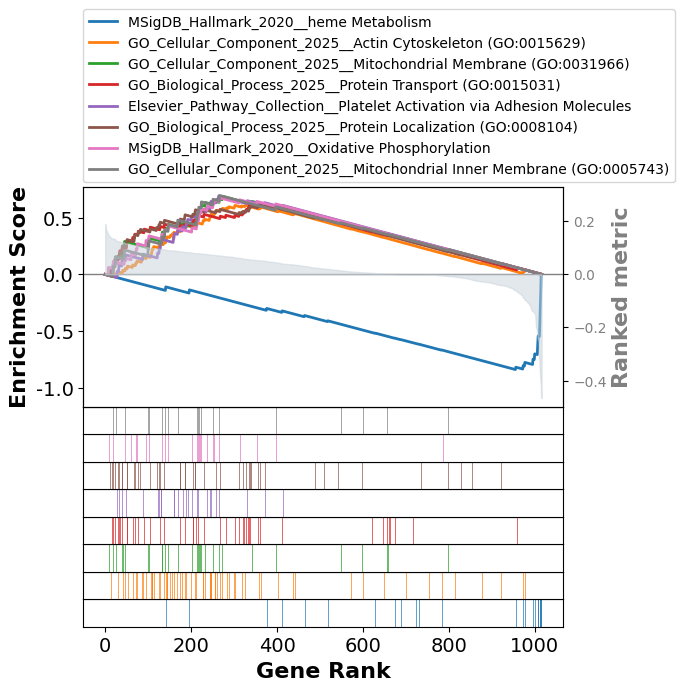

In [3]:
terms = gsea.res2d.Term
axs = gsea.plot(terms=terms[:8],
                   show_ranking=True, 
                   figsize=(3,4)
                  )

## Fast - Slow

In [4]:
ppmd = pd.read_csv("C:/Users/keimp/AAA_AMC/data/preprocessed_meta_data.csv", delimiter=";")
ppmd = ppmd[["Sample_index", "Growth group"]]
ppmd["Sample_index"] = ppmd["Sample_index"].apply(lambda x: x.replace("_", " ") if isinstance(x, str) else x)

df = pd.merge(df, ppmd, on="Sample_index", how="left")
df_growth = df[(df["Growth group"]=="Fast growth") | (df["Growth group"]=="Slow growth")]
df_growth["Growth group"].value_counts()
df_growth = df_growth.reset_index(drop=True)
df_growth.head()

,Sample_index,MAPK1,F8A1,SUGT1,RBX1,PEPD,EEF1G,VTA1,LSM5,PFDN1,...,Angio related familial history,Post OP growth (WIP),Type Aneurysms,...26,Remark,In_Tara_patientfile,From BioBank,In PAREL biobank,Metformine,Growth group
0,Sample 7,10.487751,8.314826,9.618045,9.384979,8.622801,11.524775,8.984585,9.307338,10.379843,...,Nee,NaN,Juxtarenal,NaN,Had a TIA in 2017,NaN,NaN,Ja,Nee,Fast growth
1,Sample 11,9.926743,7.848199,8.453306,9.267809,7.763622,11.779720,8.366740,7.986404,9.855620,...,Nee,NaN,Infrarenal,NaN,NaN,Nee,NaN,Ja,Nee,Slow growth
2,Sample 12,9.344145,7.533127,7.820811,8.872124,6.519187,12.533984,8.457823,8.207068,9.375645,...,Nee,NaN,Infrarenal,NaN,NaN,NaN,NaN,Onduidelijk,Nee,Fast growth
3,Sample 13,9.784074,8.192933,8.350823,8.793516,7.790520,12.292047,8.903921,8.019645,9.428527,...,Nee,NaN,Infrarenal,NaN,Type 1 diabetes,NaN,NaN,Ja,Nee,Fast growth
4,Sample 18,9.263574,7.577477,8.193717,8.932041,7.063649,11.614114,8.657491,7.860889,9.185712,...,NaN,NaN,Suprarenal,NaN,Father also died of aneurysm; died day later d...,Ja,NaN,Nee,Nee,Fast growth


In [6]:
d = DAP(df, "Sample_index", "Growth group", proteins)
d.missing_filtering(25, percentage=True)
d.exponentiate()
t = d.fold_change("Slow growth", "Fast growth", log=True, logged=False)
t = pd.DataFrame.from_dict(t, orient='index', columns=['FoldChange'])
t = t.reset_index(names='Gene')
t["pvalue"] = d.protein_batch_ttest().values()
t["rank"] = -np.log10(t.pvalue)*t.FoldChange
rnk = t.sort_values(by='rank', ascending=False)
rnk = rnk[["Gene", "rank"]]
gsea = gp.prerank(rnk=rnk, gene_sets=["dbGaP", "MSigDB_Hallmark_2020","GO_Biological_Process_2025","GO_Molecular_Function_2025","GO_Cellular_Component_2025", 'Elsevier_Pathway_Collection'], outdir=None)
gsea.res2d.head(20)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,Elsevier_Pathway_Collection__Coagulation Cascade,-0.725138,-1.843891,0.003215,0.064124,0.137,8/17,8.85%,F2;PROS1;F10;F5;PROZ;F9;PROC;SERPINA10
1,prerank,Elsevier_Pathway_Collection__Thrombophilia Her...,-0.725138,-1.843891,0.003215,0.064124,0.137,8/17,8.85%,F2;PROS1;F10;F5;PROZ;F9;PROC;SERPINA10
2,prerank,Elsevier_Pathway_Collection__Hereditary Thromb...,-0.725138,-1.843891,0.003215,0.064124,0.137,8/17,8.85%,F2;PROS1;F10;F5;PROZ;F9;PROC;SERPINA10
3,prerank,GO_Cellular_Component_2025__Nucleus (GO:0005634),0.538527,1.787688,0.0,0.08188,0.073,123/206,39.04%,S100A9;S100A8;DIAPH1;MYCBP;RUVBL1;GLRX3;COPS7B...
4,prerank,GO_Molecular_Function_2025__Peptidase Inhibito...,-0.696104,-1.760075,0.013889,0.120665,0.309,7/15,12.29%,SERPIND1;ITIH2;PROS1;LPA;AHSG;ITIH3;SERPINF2
5,prerank,GO_Cellular_Component_2025__Mitochondrial Memb...,0.670725,1.733354,0.0,0.091762,0.154,18/30,24.48%,HSPA9;MAVS;UQCRB;ATP5F1A;UQCRC1;RAC2;YWHAE;PGR...
6,prerank,MSigDB_Hallmark_2020__heme Metabolism,0.707293,1.716813,0.002981,0.079056,0.19,5/23,8.75%,HBB;HBD;TFRC;DMTN;ENDOD1
7,prerank,GO_Cellular_Component_2025__Intracellular Memb...,0.505565,1.705089,0.0,0.072704,0.219,139/253,37.17%,S100A9;S100A8;TFRC;DIAPH1;MYCBP;PACSIN2;RUVBL1...
8,prerank,GO_Biological_Process_2025__Cholesterol Homeos...,-0.645823,-1.703394,0.01,0.136696,0.439,10/18,13.37%,CETP;APOB;APOC3;PCSK9;APOC2;APOA1;APOA5;APOM;L...
9,prerank,GO_Biological_Process_2025__Sterol Homeostasis...,-0.645823,-1.703394,0.01,0.136696,0.439,10/18,13.37%,CETP;APOB;APOC3;PCSK9;APOC2;APOA1;APOA5;APOM;L...
